In [1]:
# import the dependencies
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, CategoricalEncoder
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in the Data and Prepare for Fitting Models

In [2]:
df = pd.read_csv("reduced-data2.csv")

In [3]:
df.shape

(5872, 56)

In [4]:
df.head()

,CASEID,V6309,V5114,V5118,V5113,V5115,V5112,V4428,V4433,V6305,...,PDLT,PTLT,AGOLT1,AGOLT2,PTSDLT,NAPLT,AABLT,CDLT,ASPLT1,ASPLT2
0,20001,NO,VERY,A LITTLE,SOMEWHAT,SOMEWHAT,SOMEWHAT,A LITTLE TRUE,VERY TRUE,YES,...,Present,Present,Present,Absent,Present,Absent,Absent,Absent,Absent,Absent
1,20002,NO,A LITTLE,A LITTLE,SOMEWHAT,A LITTLE,SOMEWHAT,A LITTLE TRUE,NOT TRUE AT ALL,NO,...,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent
2,20003,NO,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT AT ALL,NOT TRUE AT ALL,NOT TRUE AT ALL,NO,...,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Present,Absent,Absent
3,20004,NO,SOMEWHAT,SOMEWHAT,A LITTLE,A LITTLE,A LITTLE,A LITTLE TRUE,NOT TRUE AT ALL,NO,...,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent
4,20005,NO,A LITTLE,A LITTLE,A LITTLE,A LITTLE,SOMEWHAT,SOMEWHAT TRUE,A LITTLE TRUE,NO,...,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Absent


# Convert Categorical Variables to 0-1 Coded Variables
We use Pandas `get_dummies` to convert the categorical variables to one-hot encoded variables for fitting

In [5]:
num_attribs = ['AGE']
response = ['V6309']
cat_attribs = df.columns.tolist()
cat_attribs.remove('V6309')
cat_attribs.remove('AGE')
cat_attribs.remove('CASEID')

In [6]:
df_with_dummies = pd.get_dummies(df[cat_attribs], dummy_na=True, drop_first=True)
df_with_dummies['AGE'] = df['AGE']
df_with_dummies['response'] = df['V6309']
df_with_dummies.head()

,V5114_DK,V5114_INAP,V5114_NOT AT ALL,V5114_SOMEWHAT,V5114_VERY,V5114_nan,V5118_DK,V5118_INAP,V5118_NOT AT ALL,V5118_SOMEWHAT,...,AABLT_Present,AABLT_nan,CDLT_Present,CDLT_nan,ASPLT1_Present,ASPLT1_nan,ASPLT2_Present,ASPLT2_nan,AGE,response
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,NO
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,36,NO
2,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,34,NO
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,36,NO
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,NO


# Set Aside Testing Data

In [7]:
# Make a train-test split:
train_set, test_set = train_test_split(df_with_dummies, random_state=1, stratify=df_with_dummies['response'])

In [8]:
print(train_set.shape, test_set.shape)

(4404, 162) (1468, 162)


In [9]:
# What is the distribution of the response in the training and testing data
print("train: ")
print(train_set['response'].value_counts())
print("test: ")
print(test_set['response'].value_counts())

train: 
NO     4130
YES     274
Name: response, dtype: int64
test: 
NO     1376
YES      92
Name: response, dtype: int64


In [10]:
# We will need to identify the categorical attributes for later
cat_attribs = df_with_dummies.columns.tolist()
cat_attribs.remove('AGE')
cat_attribs.remove('response')
len(cat_attribs)

160

# Use Scikit-Learn Pipeline
The pipeline can be used to automate selection from a dataframe and transformation

In [11]:
# Define a method to select attributes from a DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# We will need this later
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('std_scaler', StandardScaler())
    #('encoder', LabelBinarizer(sparse=False, handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])


In [12]:
y_train = train_set['response']

# Prepare the training data with the pipeline above
X_train_prepared = full_pipeline.fit_transform(train_set)
X_train_prepared

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.47333761, -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ],
       [-0.83996019, -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ],
       [ 0.47333761, -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ],
       ...,
       [ 0.09810967, -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ],
       [ 1.69282842, -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ],
       [-0.7461532 , -0.01507043, -0.02131523, ...,  0.        ,
        -0.20037754,  0.        ]])

In [13]:
X_train_prepared.shape

(4404, 161)

In [14]:
y_test = test_set.response

X_test_prepared = full_pipeline.transform(test_set)
X_test_prepared.shape

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(1468, 161)

# Logistic Regression with L1 Regularization

In [15]:
### from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, multi_class='auto', n_jobs=-1,verbose=3)

In [16]:
classifier.fit(X_train_prepared, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 805 epochs took 8 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False)

In [17]:
print(f"Training Data Score: {classifier.score(X_train_prepared, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_prepared, y_test)}")

Training Data Score: 0.9595821980018165
Testing Data Score: 0.9516348773841962


In [18]:
y_test_pred = classifier.predict(X_test_prepared)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          NO       0.97      0.98      0.97      1376
         YES       0.65      0.49      0.56        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.81      0.74      0.77      1468
weighted avg       0.95      0.95      0.95      1468



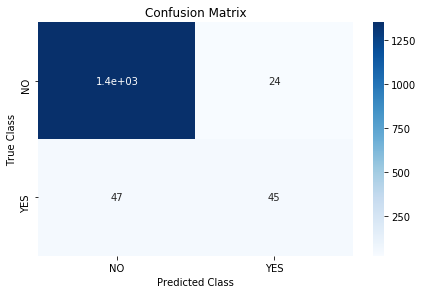

In [20]:
# We can visualize where the classifier is making errors using a confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mx = confusion_matrix(y_test, y_test_pred)
conf_df= pd.DataFrame(conf_mx, index=classifier.classes_, columns=classifier.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(conf_df, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# Search for a Model that Fits Better

In [21]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50]}

In [22]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(classifier, param_grid, cv=3, verbose=3, n_jobs=-1)

In [23]:
grid.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:    8.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   20.8s remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed:   29.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   32.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 805 epochs took 9 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [24]:
grid.best_params_

{'C': 1}

In [25]:
# Now search around the neigborhood of .2 for a better fit
param_grid = {'C': [0.25, 0.5, 1, 1.5, 2, 4]}

In [26]:
grid = GridSearchCV(classifier, param_grid, cv=3, verbose=3, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  18 | elapsed:   13.7s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   17.2s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  16 out of  18 | elapsed:   28.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   29.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 770 epochs took 8 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.25, 0.5, 1, 1.5, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [27]:
grid.best_params_

{'C': 0.5}

In [28]:
grid.best_score_

0.9518619436875567

In [29]:
# Search around 0.5 for a better fit
param_grid = {'C': [0.4, 0.45, 0.5, 0.55, 0.65]}
grid = GridSearchCV(classifier, param_grid, cv=3, verbose=3, n_jobs=-1)
grid.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   15.6s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:   17.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 770 epochs took 8 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='auto',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=3, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.4, 0.45, 0.5, 0.55, 0.65]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [30]:
grid.best_params_

{'C': 0.5}

# Look at the Coefficients for the Model
Giving that the predictors are scaled, these coefficients are not in the original X scale; therefore, we can't
interpret them as changes in log-odds ratios for a unit change in X.  They are for a unit change in the scaled-X.

In [31]:
attributes = num_attribs + cat_attribs
# The estimated coefficients
final_model = grid.best_estimator_
fit_coefs = final_model.coef_

for feat_imp in sorted(zip(fit_coefs[0], attributes), reverse=True):
    print(feat_imp)

(1.405701337560204, 'V6301_YES')
(0.3352195750470491, 'V6305_YES')
(0.2671164313020904, 'V5112_VERY')
(0.22015957132804237, 'MANLT1_Present')
(0.19494370902353256, 'AGOLT2_Present')
(0.18736349415195822, 'GADLT2_Present')
(0.18675774985950044, 'RACE_Other')
(0.16174613307282618, 'V5114_NOT AT ALL')
(0.16002924681466746, 'V4428_NOT TRUE AT ALL')
(0.15724323368953683, 'DEPLT1_Present')
(0.14607752509787442, 'V6143_YES')
(0.1430697901922478, 'V5114_VERY')
(0.11598458523722524, 'CDLT_Present')
(0.10503895609765034, 'V6649_YES')
(0.10190826038717035, 'V4428_SOMEWHAT TRUE')
(0.09375797311412458, 'EMP_Other')
(0.08748711777071935, 'DRGDLT_Present')
(0.08443841285707145, 'V4433_VERY TRUE')
(0.0829091185713951, 'MARSTAT_Marswd')
(0.06514093684339116, 'V5114_SOMEWHAT')
(0.06350573040197083, 'V102_FAIR')
(0.06312178119692206, 'EMP_Working, incl. temp. laid off, matern./s')
(0.062007599401439885, 'DYSLT2_Present')
(0.05925001111695777, 'V4433_nan')
(0.05428073619424966, 'V5118_SOMEWHAT')
(0.050831

In [32]:
final_model = grid.best_estimator_

In [33]:
y_test_pred = final_model.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          NO       0.97      0.98      0.98      1376
         YES       0.69      0.50      0.58        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.83      0.74      0.78      1468
weighted avg       0.95      0.95      0.95      1468



# The ROC Curve for our Classifier

In [34]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(final_model, X_train_prepared, y_train, cv=3, method="decision_function", n_jobs=-1)

In [35]:
y_train_0 = pd.get_dummies(y_train, drop_first=True).values

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

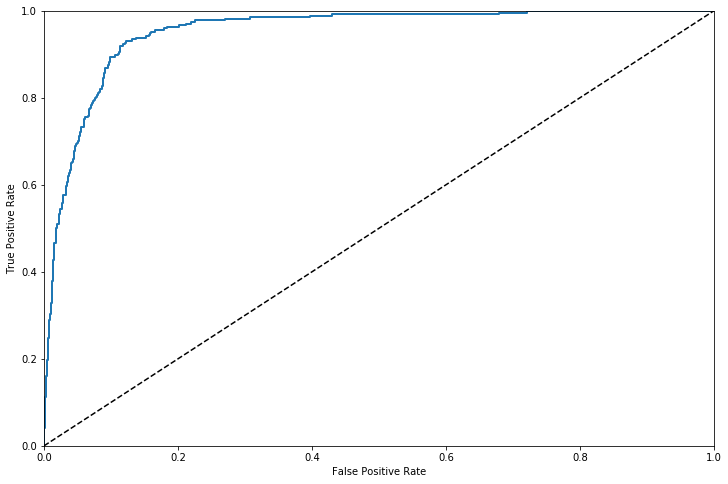

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
from sklearn.metrics import precision_recall_curve

In [39]:
y_scores = cross_val_predict(final_model, X_train_prepared, y_train_0.reshape((-1,1)), cv=3, method="decision_function", n_jobs=-1)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

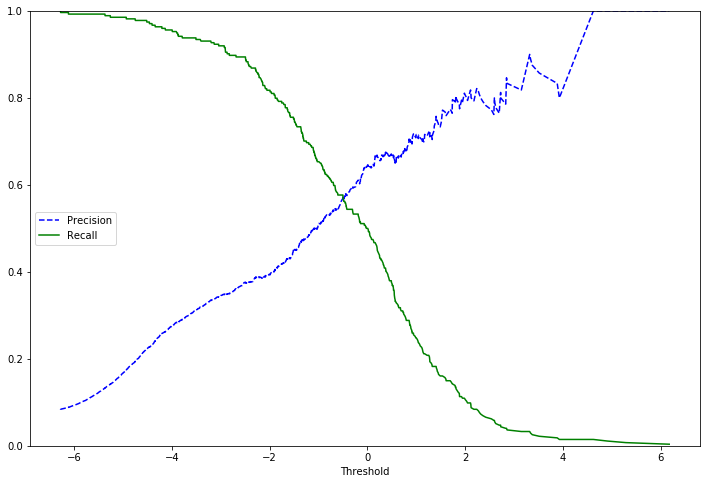

In [41]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.savefig("newprecvsrecall.png")
plt.show()

Text(0, 0.5, 'Precisions')

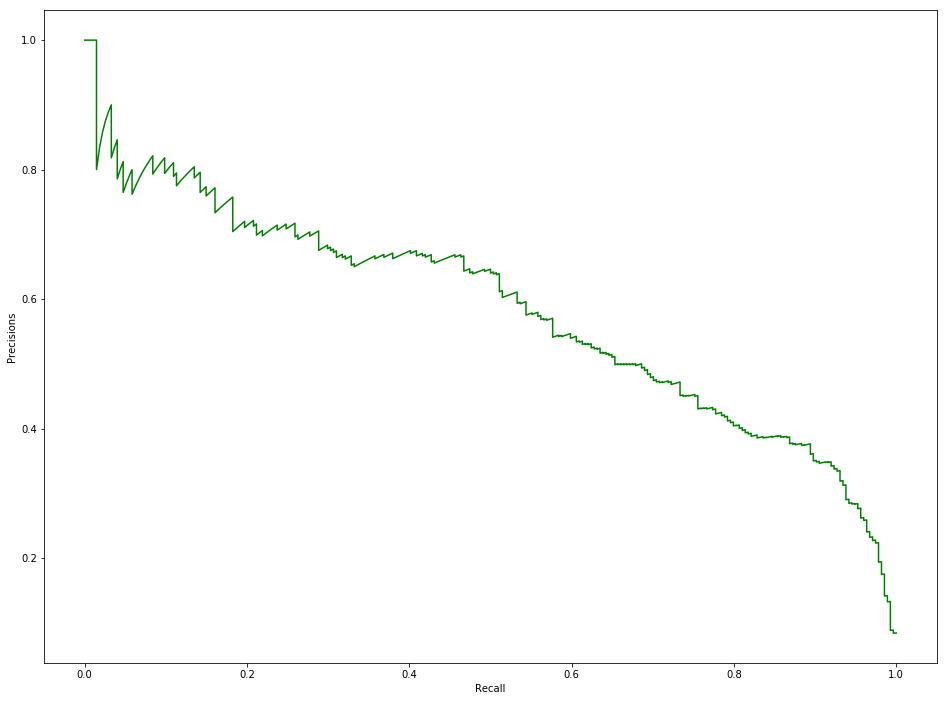

In [42]:
plt.figure(figsize=(16,12))
plt.plot(recalls, precisions, 'g-')
plt.xlabel('Recall')
plt.ylabel('Precisions')

In [43]:
# Consider the estimator that uses a threshold of -2
y_pred_recall8 = (y_scores > -2)

In [44]:
confusion_matrix(y_train_0, y_pred_recall8)

array([[3786,  344],
       [  50,  224]], dtype=int64)

In [45]:
print(classification_report(y_train_0, y_pred_recall8))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4130
           1       0.39      0.82      0.53       274

   micro avg       0.91      0.91      0.91      4404
   macro avg       0.69      0.87      0.74      4404
weighted avg       0.95      0.91      0.92      4404



Computing regularization path ...
This took 2531.641s


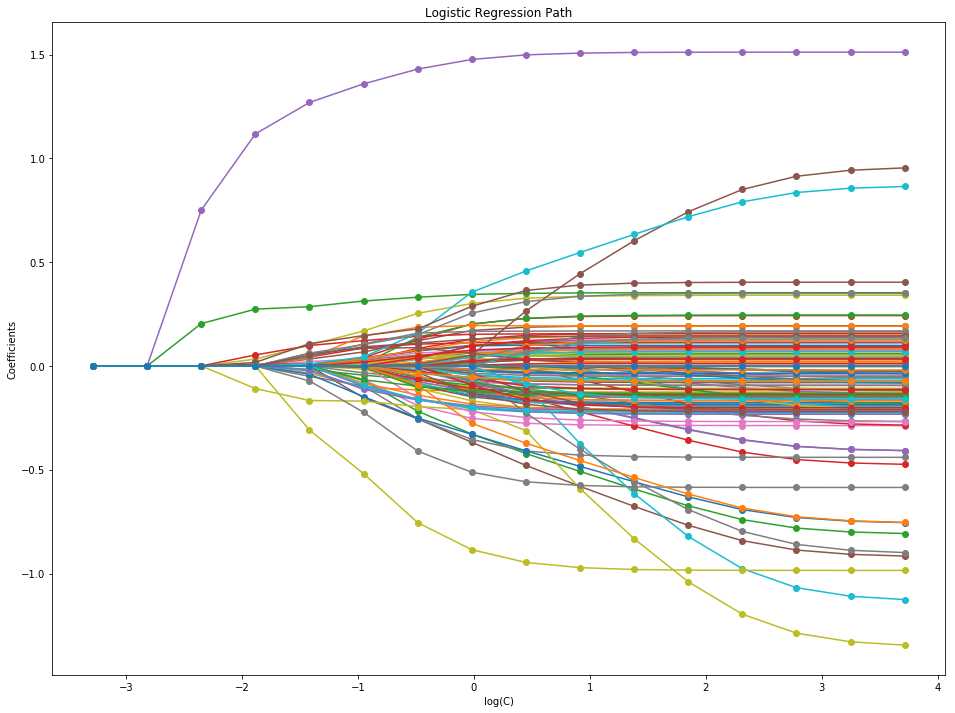

In [46]:
from sklearn import linear_model
from sklearn.svm import l1_min_c
from time import time

X = X_train_prepared
y = y_train

#X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True, n_jobs=-1)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.figure(figsize=(16,12))
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

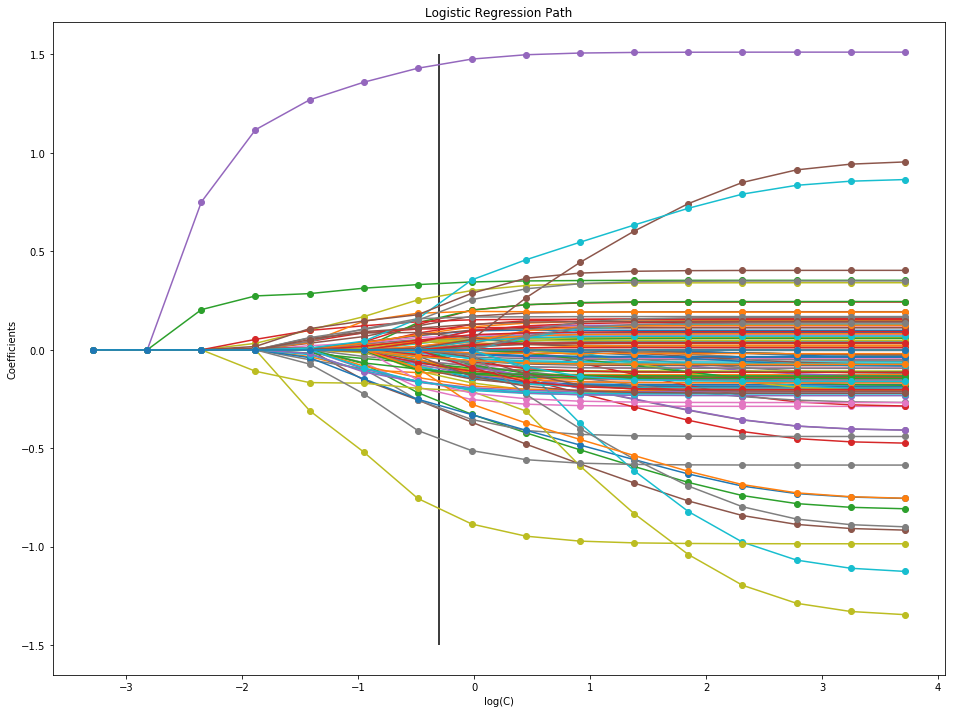

In [47]:
coefs_ = np.array(coefs_)
plt.figure(figsize=(16,12))
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.vlines(np.log10(0.5), ymin=-1.5, ymax=1.5)
plt.axis('tight')
plt.show()

# Consider a Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_prepared, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [49]:
y_test_pred = tree_clf.predict(X_test_prepared)

In [50]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          NO       0.96      0.96      0.96      1376
         YES       0.44      0.48      0.46        92

   micro avg       0.93      0.93      0.93      1468
   macro avg       0.70      0.72      0.71      1468
weighted avg       0.93      0.93      0.93      1468



# Random Forest Classifier

In [51]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_clf.fit(X_train_prepared, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
y_test_pred_rf = forest_clf.predict(X_test_prepared)

In [53]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

          NO       0.95      1.00      0.97      1376
         YES       0.84      0.17      0.29        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.89      0.59      0.63      1468
weighted avg       0.94      0.95      0.93      1468



# Use GridSearchCV to Find Good Parameter Values

In [ ]:
# param_grid = {'n_estimators': [50, 100, 200, 300, 500, 1000]}
grid_rf = GridSearchCV(forest_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_rf.fit(X_train_prepared, y_train)

In [55]:
print(grid_rf.best_score_)

0.9425522252497729


In [56]:
print(grid_rf.best_params_)

{'n_estimators': 100}


In [57]:
# Search in the neighborhood of the last best parameter
param_grid = {'n_estimators': [75, 100, 125, 150, 175]}
grid_rf = GridSearchCV(forest_clf, param_grid, verbose=3, n_jobs=-1)
grid_rf.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    0.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [75, 100, 125, 150, 175]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [58]:
print(grid_rf.best_params_)

{'n_estimators': 125}


In [59]:
attributes = num_attribs + cat_attribs
feature_importances = grid_rf.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.10755386024112401, 'V6301_YES'),
 (0.0908345872070841, 'V6305_YES'),
 (0.04350145559367754, 'AGE'),
 (0.015613144229875394, 'V6143_YES'),
 (0.015241500775520753, 'DEPLT1_Present'),
 (0.014894860667925383, 'V6114_YES'),
 (0.014805054182319395, 'PTSDLT_Present'),
 (0.012691666173890009, 'V6114_NO'),
 (0.012311468668419227, 'V4433_VERY TRUE'),
 (0.011920554714885463, 'DEPLT2_Present'),
 (0.011704663914660919, 'REL_Protestant'),
 (0.011294222393965134, 'SEX_Male'),
 (0.011009287961654244, 'V5225_INAP'),
 (0.01091630486145782, 'DRGDLT_Present'),
 (0.0108160580299, 'EDCAT_12 Years'),
 (0.010733574684887916, 'CDLT_Present'),
 (0.010599176628869241, 'V102_GOOD'),
 (0.010561934872039984, 'V5115_SOMEWHAT'),
 (0.010539192112571674, 'V5112_SOMEWHAT'),
 (0.010483184336859042, 'V5118_SOMEWHAT'),
 (0.010473474169019273, 'V5113_SOMEWHAT'),
 (0.010409492036284827, 'V6649_NO'),
 (0.010363377859609859, 'V6215_TWO OR MORE YES RESPONSES IN U1-U12'),
 (0.010325874678015743, 'V5918_OFTEN'),
 (0.010214086

In [60]:
y_test_pred_rf = grid_rf.best_estimator_.predict(X_test_prepared)

In [61]:
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

          NO       0.95      1.00      0.97      1376
         YES       0.84      0.17      0.29        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.89      0.59      0.63      1468
weighted avg       0.94      0.95      0.93      1468



# Compare the ROC Curves - Random Forest and L1 Logistic Regression

In [62]:
y_probas_forest = cross_val_predict(grid_rf.best_estimator_, X_train_prepared, y_train_0, cv=3, method="predict_proba")

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_0, y_scores_forest)

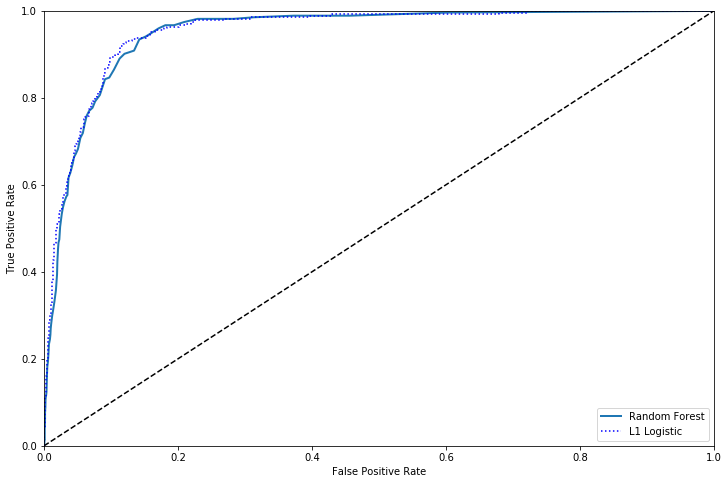

In [64]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="L1 Logistic")
plt.legend(loc="lower right")
plt.show()

# AdaBoost

In [65]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf =  AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=500,
                           algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train_prepared, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None)

In [66]:
print(f"Training Data Score: {ada_clf.score(X_train_prepared, y_train)}")
print(f"Testing Data Score: {ada_clf.score(X_test_prepared, y_test)}")

Training Data Score: 0.9543596730245232
Testing Data Score: 0.944141689373297


In [67]:
print(classification_report(y_test, ada_clf.predict(X_test_prepared)))

              precision    recall  f1-score   support

          NO       0.96      0.98      0.97      1376
         YES       0.57      0.43      0.49        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.77      0.71      0.73      1468
weighted avg       0.94      0.94      0.94      1468



In [68]:
param_grid = {'n_estimators': [250, 500, 750, 1000, 1500]}
grid_ada = GridSearchCV(ada_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_ada.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   17.4s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   31.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   39.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [250, 500, 750, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [69]:
grid_ada.best_score_

0.9477747502270663

In [70]:
grid_ada.best_params_

{'n_estimators': 750}

In [71]:
# Search again in a neighborhood of the last best value
param_grid = {'n_estimators': [600, 650, 700, 750, 800, 850]}
grid_ada = GridSearchCV(ada_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_ada.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:   31.9s remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   41.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=500, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [600, 650, 700, 750, 800, 850]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [72]:
grid_ada.best_params_

{'n_estimators': 650}

In [73]:
y_test_pred_ada = grid_ada.best_estimator_.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred_ada))

              precision    recall  f1-score   support

          NO       0.96      0.98      0.97      1376
         YES       0.59      0.45      0.51        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.77      0.71      0.74      1468
weighted avg       0.94      0.95      0.94      1468



In [74]:
feature_importances = grid_ada.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38, 'AGE'),
 (0.03538461538461538, 'EDCAT_16+ Years'),
 (0.03538461538461538, 'EDCAT_13-15 Years'),
 (0.027692307692307693, 'V6301_YES'),
 (0.024615384615384615, 'EDCAT_12 Years'),
 (0.018461538461538463, 'V5112_VERY'),
 (0.016923076923076923, 'AGOLT2_Present'),
 (0.015384615384615385, 'V5225_INAP'),
 (0.015384615384615385, 'V5114_VERY'),
 (0.015384615384615385, 'V5113_VERY'),
 (0.015384615384615385, 'SIMLT_Present'),
 (0.015384615384615385, 'AGOLT1_Present'),
 (0.013846153846153847, 'V4428_NOT TRUE AT ALL'),
 (0.012307692307692308, 'V5225_NOT AT ALL'),
 (0.012307692307692308, 'V5118_VERY'),
 (0.012307692307692308, 'V101_FAIR'),
 (0.010769230769230769, 'V5114_NOT AT ALL'),
 (0.010769230769230769, 'V102_GOOD'),
 (0.010769230769230769, 'EMP_Working, incl. temp. laid off, matern./s'),
 (0.010769230769230769, 'DEPLT1_Present'),
 (0.009230769230769232, 'V6305_YES'),
 (0.009230769230769232, 'V5225_SOME'),
 (0.009230769230769232, 'V5115_VERY'),
 (0.009230769230769232, 'V5115_NOT AT ALL'),

# Support Vector Machine

In [75]:
from sklearn.svm import SVC
svc_clf = SVC(kernel='rbf')
svc_clf.fit(X_train_prepared, np.ravel(y_train_0))

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [76]:
svc_clf.score(X_train_prepared, np.ravel(y_train_0))

0.9747956403269755

In [77]:
y_test_0 = np.ravel(pd.get_dummies(y_test, drop_first=True))
svc_clf.score(X_test_prepared, y_test_0)

0.9495912806539509

In [78]:
y_test_pred = svc_clf.predict(X_test_prepared)

In [79]:
print(classification_report(y_test_0, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1376
           1       0.91      0.22      0.35        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.93      0.61      0.66      1468
weighted avg       0.95      0.95      0.93      1468



In [81]:
param_grid = {'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_svc = GridSearchCV(svc_clf, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_svc.fit(X_train_prepared, y_train_0)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  30 | elapsed:    6.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.5s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [82]:
grid_svc.best_params_

{'C': 2.0}

In [83]:
y_pred = grid_svc.best_estimator_.predict(X_test_prepared)

In [84]:
print(classification_report(y_test_0, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1376
           1       0.78      0.35      0.48        92

   micro avg       0.95      0.95      0.95      1468
   macro avg       0.87      0.67      0.73      1468
weighted avg       0.95      0.95      0.94      1468



In [89]:
param_grid = {'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}
grid_svc = GridSearchCV(svc_clf, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_svc.fit(X_train_prepared, y_train_0)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.9s finished
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 'kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [90]:
grid_svc.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [92]:
print(classification_report(y_test_0, grid_svc.best_estimator_.predict(X_test_prepared)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1376
           1       0.78      0.47      0.59        92

   micro avg       0.96      0.96      0.96      1468
   macro avg       0.87      0.73      0.78      1468
weighted avg       0.95      0.96      0.95      1468



In [93]:
# The estimated coefficients
final_model = grid_svc.best_estimator_
fit_coefs = final_model.coef_

for feat_imp in sorted(zip(fit_coefs[0], attributes), reverse=True):
    print(feat_imp)

(0.33134098055022654, 'V6301_YES')
(0.2658762878959282, 'V6305_YES')
(0.09601222831579709, 'V5112_VERY')
(0.09120182519756398, 'MANLT1_Present')
(0.08898480797853073, 'V5114_NOT AT ALL')
(0.08380641696304081, 'AGOLT2_Present')
(0.07231667313315937, 'EMP_Other')
(0.07083817425588879, 'V6143_YES')
(0.06778311310203655, 'CDLT_Present')
(0.06479150875929443, 'V6649_YES')
(0.06352508056857867, 'RACE_Other')
(0.06188795212604514, 'V4433_VERY TRUE')
(0.05840809338128916, 'BP1LT1_Present')
(0.05255439262703554, 'DEPLT1_Present')
(0.05223634471497457, 'GADLT2_Present')
(0.04988952221870918, 'EMP_Working, incl. temp. laid off, matern./s')
(0.04792998851427771, 'V5112_NOT AT ALL')
(0.04725943336802352, 'DRGDLT_Present')
(0.047254406464222, 'V5114_SOMEWHAT')
(0.04709133519398351, 'V4428_NOT TRUE AT ALL')
(0.04194618791251941, 'V4428_SOMEWHAT TRUE')
(0.040329985180114325, 'V102_FAIR')
(0.03788601795737362, 'V4433_nan')
(0.03690043608135468, 'DYSLT2_Present')
(0.0362625327220939, 'V5114_VERY')
(0.03

In [94]:
# We see a pattern in the coefficients similar to before

# Neural Nets

In [97]:
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
print(X_train_prepared.shape)
print(y_train.shape)
print(X_test_prepared.shape)
print(y_test.shape)

(4404, 161)
(4404, 1)
(1468, 161)
(1468, 1)


In [113]:
#from sklearn.preprocessing import LabelEncoder

#Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(np.ravel(y_train))

from keras.utils import to_categorical

# Step 2: One-hot encoding
y_train_categorical = to_categorical(encoded_y_train)
y_train_categorical

# Repeat for test data
label_encoder = LabelEncoder()
label_encoder.fit(y_test)
encoded_y_test = label_encoder.transform(np.ravel(y_test))

# Step 2: One-hot encoding
y_test_categorical = to_categorical(encoded_y_test)
y_test_categorical

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [114]:
print(y_train_categorical.sum(axis=0))
print(y_test_categorical.sum(axis=0))

[4130.  274.]
[1376.   92.]


In [115]:
y_train_categorical.shape

(4404, 2)

In [116]:
from tensorflow.keras.models import Sequential

model = Sequential()

In [117]:
from tensorflow.keras.layers import Dense
number_inputs = 161
number_hidden_nodes = 12
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))

Instructions for updating:
Colocations handled automatically by placer.


In [118]:
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))

In [119]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                1944      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 26        
Total params: 1,970
Trainable params: 1,970
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [122]:
model.fit(
    X_train_prepared,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 0s - loss: 0.5779 - acc: 0.7128
Epoch 2/1000
 - 0s - loss: 0.2336 - acc: 0.9289
Epoch 3/1000
 - 0s - loss: 0.1729 - acc: 0.9385
Epoch 4/1000
 - 0s - loss: 0.1469 - acc: 0.9435
Epoch 5/1000
 - 0s - loss: 0.1313 - acc: 0.9489
Epoch 6/1000
 - 0s - loss: 0.1206 - acc: 0.9544
Epoch 7/1000
 - 0s - loss: 0.1130 - acc: 0.9550
Epoch 8/1000
 - 0s - loss: 0.1061 - acc: 0.9598
Epoch 9/1000
 - 0s - loss: 0.1009 - acc: 0.9616
Epoch 10/1000
 - 0s - loss: 0.0967 - acc: 0.9650
Epoch 11/1000
 - 0s - loss: 0.0928 - acc: 0.9641
Epoch 12/1000
 - 0s - loss: 0.0892 - acc: 0.9668
Epoch 13/1000
 - 0s - loss: 0.0858 - acc: 0.9671
Epoch 14/1000
 - 0s - loss: 0.0827 - acc: 0.9709
Epoch 15/1000
 - 0s - loss: 0.0799 - acc: 0.9709
Epoch 16/1000
 - 0s - loss: 0.0770 - acc: 0.9723
Epoch 17/1000
 - 0s - loss: 0.0742 - acc: 0.9750
Epoch 18/1000
 - 0s - loss: 0.0718 - acc: 0.9764
Epoch 19/1000
 - 0s - loss: 0.0688 - acc: 0.9766
Epoch 20/1000
 - 0s - loss: 0.

 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 162/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 163/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 164/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 165/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 166/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 167/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 168/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 169/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 170/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 171/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 172/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 173/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 174/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 175/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 176/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 177/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 178/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 179/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 180/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 181/1000


 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 326/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 327/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 328/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 329/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 330/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 331/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 332/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 333/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 334/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 335/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 336/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 337/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 338/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 339/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 340/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 341/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 342/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 343/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 344/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 345/1000


 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 490/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 491/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 492/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 493/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 494/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 495/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 496/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 497/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 498/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 499/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 500/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 501/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 502/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 503/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 504/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 505/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 506/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 507/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 508/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 509/1000


 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 654/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 655/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 656/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 657/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 658/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 659/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 660/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 661/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 662/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 663/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 664/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 665/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 666/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 667/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 668/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 669/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 670/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 671/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 672/1000
 - 0s - loss: 0.0037 - acc: 0.9998
Epoch 673/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 818/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 819/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 820/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 821/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 822/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 823/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 824/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 825/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 826/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 827/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 828/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 829/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 830/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 831/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 832/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 833/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 834/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 835/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 836/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 837/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 982/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 983/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 984/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 985/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 986/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 987/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 988/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 989/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 990/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 991/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 992/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 993/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 994/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 995/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 996/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 997/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 998/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 999/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 1000/1000
 - 0s - loss: 0.0146 - acc: 0.9991


In [124]:
model_loss, model_accuracy = model.evaluate(
    X_test_prepared, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

 - 0s - loss: 0.7648 - acc: 0.9394
Loss: 0.7647937373290253, Accuracy: 0.9393733143806458


In [139]:
y_pred = model.predict(X_test_prepared, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

1468/1468 [==============================] - 0s 11us/sample
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1376
           1       0.52      0.47      0.49        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.74      0.72      0.73      1468
weighted avg       0.94      0.94      0.94      1468



In [144]:
# Drop the number of hidden units
model = Sequential()
number_inputs = 161
number_hidden_nodes = 2
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 324       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 6         
Total params: 330
Trainable params: 330
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [146]:
model.fit(
    X_train_prepared,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

Epoch 1/1000
 - 0s - loss: 0.7649 - acc: 0.7105
Epoch 2/1000
 - 0s - loss: 0.4743 - acc: 0.8971
Epoch 3/1000
 - 0s - loss: 0.3513 - acc: 0.9326
Epoch 4/1000
 - 0s - loss: 0.2771 - acc: 0.9394
Epoch 5/1000
 - 0s - loss: 0.2312 - acc: 0.9410
Epoch 6/1000
 - 0s - loss: 0.2056 - acc: 0.9450
Epoch 7/1000
 - 0s - loss: 0.1891 - acc: 0.9460
Epoch 8/1000
 - 0s - loss: 0.1769 - acc: 0.9464
Epoch 9/1000
 - 0s - loss: 0.1673 - acc: 0.9482
Epoch 10/1000
 - 0s - loss: 0.1595 - acc: 0.9507
Epoch 11/1000
 - 0s - loss: 0.1530 - acc: 0.9505
Epoch 12/1000
 - 0s - loss: 0.1469 - acc: 0.9535
Epoch 13/1000
 - 0s - loss: 0.1408 - acc: 0.9541
Epoch 14/1000
 - 0s - loss: 0.1354 - acc: 0.9541
Epoch 15/1000
 - 0s - loss: 0.1308 - acc: 0.9539
Epoch 16/1000
 - 0s - loss: 0.1273 - acc: 0.9548
Epoch 17/1000
 - 0s - loss: 0.1238 - acc: 0.9559
Epoch 18/1000
 - 0s - loss: 0.1211 - acc: 0.9553
Epoch 19/1000
 - 0s - loss: 0.1183 - acc: 0.9562
Epoch 20/1000
 - 0s - loss: 0.1165 - acc: 0.9557
Epoch 21/1000
 - 0s - loss: 0

 - 0s - loss: 0.0874 - acc: 0.9630
Epoch 168/1000
 - 0s - loss: 0.0875 - acc: 0.9639
Epoch 169/1000
 - 0s - loss: 0.0871 - acc: 0.9644
Epoch 170/1000
 - 0s - loss: 0.0875 - acc: 0.9625
Epoch 171/1000
 - 0s - loss: 0.0876 - acc: 0.9632
Epoch 172/1000
 - 0s - loss: 0.0872 - acc: 0.9630
Epoch 173/1000
 - 0s - loss: 0.0874 - acc: 0.9628
Epoch 174/1000
 - 0s - loss: 0.0881 - acc: 0.9623
Epoch 175/1000
 - 0s - loss: 0.0888 - acc: 0.9632
Epoch 176/1000
 - 0s - loss: 0.0871 - acc: 0.9632
Epoch 177/1000
 - 0s - loss: 0.0873 - acc: 0.9632
Epoch 178/1000
 - 0s - loss: 0.0870 - acc: 0.9639
Epoch 179/1000
 - 0s - loss: 0.0874 - acc: 0.9634
Epoch 180/1000
 - 0s - loss: 0.0883 - acc: 0.9623
Epoch 181/1000
 - 0s - loss: 0.0878 - acc: 0.9632
Epoch 182/1000
 - 0s - loss: 0.0879 - acc: 0.9634
Epoch 183/1000
 - 0s - loss: 0.0876 - acc: 0.9628
Epoch 184/1000
 - 0s - loss: 0.0869 - acc: 0.9639
Epoch 185/1000
 - 0s - loss: 0.0875 - acc: 0.9641
Epoch 186/1000
 - 0s - loss: 0.0873 - acc: 0.9621
Epoch 187/1000


 - 0s - loss: 0.0874 - acc: 0.9648
Epoch 332/1000
 - 0s - loss: 0.0862 - acc: 0.9639
Epoch 333/1000
 - 0s - loss: 0.0858 - acc: 0.9641
Epoch 334/1000
 - 0s - loss: 0.0859 - acc: 0.9628
Epoch 335/1000
 - 0s - loss: 0.0868 - acc: 0.9653
Epoch 336/1000
 - 0s - loss: 0.0861 - acc: 0.9641
Epoch 337/1000
 - 0s - loss: 0.0857 - acc: 0.9644
Epoch 338/1000
 - 0s - loss: 0.0854 - acc: 0.9637
Epoch 339/1000
 - 0s - loss: 0.0855 - acc: 0.9630
Epoch 340/1000
 - 0s - loss: 0.0854 - acc: 0.9641
Epoch 341/1000
 - 0s - loss: 0.0855 - acc: 0.9641
Epoch 342/1000
 - 0s - loss: 0.0862 - acc: 0.9646
Epoch 343/1000
 - 0s - loss: 0.0860 - acc: 0.9644
Epoch 344/1000
 - 0s - loss: 0.0869 - acc: 0.9639
Epoch 345/1000
 - 0s - loss: 0.0858 - acc: 0.9634
Epoch 346/1000
 - 0s - loss: 0.0856 - acc: 0.9644
Epoch 347/1000
 - 0s - loss: 0.0854 - acc: 0.9630
Epoch 348/1000
 - 0s - loss: 0.0856 - acc: 0.9632
Epoch 349/1000
 - 0s - loss: 0.0867 - acc: 0.9630
Epoch 350/1000
 - 0s - loss: 0.0878 - acc: 0.9634
Epoch 351/1000


 - 0s - loss: 0.0860 - acc: 0.9625
Epoch 496/1000
 - 0s - loss: 0.0866 - acc: 0.9632
Epoch 497/1000
 - 0s - loss: 0.0877 - acc: 0.9644
Epoch 498/1000
 - 0s - loss: 0.0866 - acc: 0.9634
Epoch 499/1000
 - 0s - loss: 0.0858 - acc: 0.9634
Epoch 500/1000
 - 0s - loss: 0.0856 - acc: 0.9637
Epoch 501/1000
 - 0s - loss: 0.0855 - acc: 0.9628
Epoch 502/1000
 - 0s - loss: 0.0855 - acc: 0.9634
Epoch 503/1000
 - 0s - loss: 0.0855 - acc: 0.9639
Epoch 504/1000
 - 0s - loss: 0.0856 - acc: 0.9646
Epoch 505/1000
 - 0s - loss: 0.0856 - acc: 0.9648
Epoch 506/1000
 - 0s - loss: 0.0855 - acc: 0.9625
Epoch 507/1000
 - 0s - loss: 0.0851 - acc: 0.9634
Epoch 508/1000
 - 0s - loss: 0.0852 - acc: 0.9637
Epoch 509/1000
 - 0s - loss: 0.0852 - acc: 0.9634
Epoch 510/1000
 - 0s - loss: 0.0849 - acc: 0.9639
Epoch 511/1000
 - 0s - loss: 0.0855 - acc: 0.9634
Epoch 512/1000
 - 0s - loss: 0.0862 - acc: 0.9632
Epoch 513/1000
 - 0s - loss: 0.0876 - acc: 0.9632
Epoch 514/1000
 - 0s - loss: 0.0872 - acc: 0.9641
Epoch 515/1000


 - 0s - loss: 0.0860 - acc: 0.9632
Epoch 660/1000
 - 0s - loss: 0.0855 - acc: 0.9634
Epoch 661/1000
 - 0s - loss: 0.0851 - acc: 0.9637
Epoch 662/1000
 - 0s - loss: 0.0850 - acc: 0.9639
Epoch 663/1000
 - 0s - loss: 0.0848 - acc: 0.9641
Epoch 664/1000
 - 0s - loss: 0.0847 - acc: 0.9632
Epoch 665/1000
 - 0s - loss: 0.0848 - acc: 0.9637
Epoch 666/1000
 - 0s - loss: 0.0848 - acc: 0.9644
Epoch 667/1000
 - 0s - loss: 0.0847 - acc: 0.9650
Epoch 668/1000
 - 0s - loss: 0.0850 - acc: 0.9632
Epoch 669/1000
 - 0s - loss: 0.0849 - acc: 0.9644
Epoch 670/1000
 - 0s - loss: 0.0852 - acc: 0.9641
Epoch 671/1000
 - 0s - loss: 0.0858 - acc: 0.9625
Epoch 672/1000
 - 0s - loss: 0.0887 - acc: 0.9625
Epoch 673/1000
 - 0s - loss: 0.0869 - acc: 0.9639
Epoch 674/1000
 - 0s - loss: 0.0854 - acc: 0.9637
Epoch 675/1000
 - 0s - loss: 0.0855 - acc: 0.9641
Epoch 676/1000
 - 0s - loss: 0.0850 - acc: 0.9639
Epoch 677/1000
 - 0s - loss: 0.0853 - acc: 0.9639
Epoch 678/1000
 - 0s - loss: 0.0851 - acc: 0.9644
Epoch 679/1000


 - 0s - loss: 0.0840 - acc: 0.9653
Epoch 824/1000
 - 0s - loss: 0.0841 - acc: 0.9653
Epoch 825/1000
 - 0s - loss: 0.0840 - acc: 0.9653
Epoch 826/1000
 - 0s - loss: 0.0841 - acc: 0.9653
Epoch 827/1000
 - 0s - loss: 0.0841 - acc: 0.9650
Epoch 828/1000
 - 0s - loss: 0.0841 - acc: 0.9650
Epoch 829/1000
 - 0s - loss: 0.0841 - acc: 0.9648
Epoch 830/1000
 - 0s - loss: 0.0840 - acc: 0.9648
Epoch 831/1000
 - 0s - loss: 0.0849 - acc: 0.9650
Epoch 832/1000
 - 0s - loss: 0.0859 - acc: 0.9648
Epoch 833/1000
 - 0s - loss: 0.0846 - acc: 0.9648
Epoch 834/1000
 - 0s - loss: 0.0843 - acc: 0.9659
Epoch 835/1000
 - 0s - loss: 0.0841 - acc: 0.9646
Epoch 836/1000
 - 0s - loss: 0.0840 - acc: 0.9648
Epoch 837/1000
 - 0s - loss: 0.0839 - acc: 0.9650
Epoch 838/1000
 - 0s - loss: 0.0843 - acc: 0.9648
Epoch 839/1000
 - 0s - loss: 0.0841 - acc: 0.9657
Epoch 840/1000
 - 0s - loss: 0.0840 - acc: 0.9655
Epoch 841/1000
 - 0s - loss: 0.0841 - acc: 0.9655
Epoch 842/1000
 - 0s - loss: 0.0842 - acc: 0.9662
Epoch 843/1000


 - 0s - loss: 0.0884 - acc: 0.9646
Epoch 988/1000
 - 0s - loss: 0.0880 - acc: 0.9646
Epoch 989/1000
 - 0s - loss: 0.0879 - acc: 0.9630
Epoch 990/1000
 - 0s - loss: 0.0861 - acc: 0.9657
Epoch 991/1000
 - 0s - loss: 0.0848 - acc: 0.9655
Epoch 992/1000
 - 0s - loss: 0.0841 - acc: 0.9662
Epoch 993/1000
 - 0s - loss: 0.0840 - acc: 0.9655
Epoch 994/1000
 - 0s - loss: 0.0840 - acc: 0.9650
Epoch 995/1000
 - 0s - loss: 0.0845 - acc: 0.9650
Epoch 996/1000
 - 0s - loss: 0.0851 - acc: 0.9648
Epoch 997/1000
 - 0s - loss: 0.0843 - acc: 0.9650
Epoch 998/1000
 - 0s - loss: 0.0842 - acc: 0.9655
Epoch 999/1000
 - 0s - loss: 0.0839 - acc: 0.9650
Epoch 1000/1000
 - 0s - loss: 0.0839 - acc: 0.9646


In [147]:
model_loss, model_accuracy = model.evaluate(
    X_test_prepared, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

y_pred = model.predict(X_test_prepared, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

 - 0s - loss: 0.3067 - acc: 0.9366
Loss: 0.30667610060454065, Accuracy: 0.9366484880447388
1468/1468 [==============================] - 0s 25us/sample
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1376
           1       0.49      0.43      0.46        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.73      0.70      0.71      1468
weighted avg       0.93      0.94      0.93      1468



In [148]:
# Up the number of hidden units
model = Sequential()
number_inputs = 161
number_hidden_nodes = 16
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                2592      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 2,626
Trainable params: 2,626
Non-trainable params: 0
_________________________________________________________________


In [149]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [150]:
model.fit(
    X_train_prepared,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

Epoch 1/1000
 - 0s - loss: 0.4909 - acc: 0.7986
Epoch 2/1000
 - 0s - loss: 0.1915 - acc: 0.9430
Epoch 3/1000
 - 0s - loss: 0.1509 - acc: 0.9516
Epoch 4/1000
 - 0s - loss: 0.1328 - acc: 0.9569
Epoch 5/1000
 - 0s - loss: 0.1210 - acc: 0.9589
Epoch 6/1000
 - 0s - loss: 0.1114 - acc: 0.9630
Epoch 7/1000
 - 0s - loss: 0.1043 - acc: 0.9671
Epoch 8/1000
 - 0s - loss: 0.0979 - acc: 0.9693
Epoch 9/1000
 - 0s - loss: 0.0926 - acc: 0.9718
Epoch 10/1000
 - 0s - loss: 0.0872 - acc: 0.9752
Epoch 11/1000
 - 0s - loss: 0.0829 - acc: 0.9746
Epoch 12/1000
 - 0s - loss: 0.0789 - acc: 0.9775
Epoch 13/1000
 - 0s - loss: 0.0751 - acc: 0.9777
Epoch 14/1000
 - 0s - loss: 0.0716 - acc: 0.9805
Epoch 15/1000
 - 0s - loss: 0.0691 - acc: 0.9827
Epoch 16/1000
 - 0s - loss: 0.0657 - acc: 0.9834
Epoch 17/1000
 - 0s - loss: 0.0624 - acc: 0.9837
Epoch 18/1000
 - 0s - loss: 0.0597 - acc: 0.9843
Epoch 19/1000
 - 0s - loss: 0.0570 - acc: 0.9866
Epoch 20/1000
 - 0s - loss: 0.0553 - acc: 0.9868
Epoch 21/1000
 - 0s - loss: 0

 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 168/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 169/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 170/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 171/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 172/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 173/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 174/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 175/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 176/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 177/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 178/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 179/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 180/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 181/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 182/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 183/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 184/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 185/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 186/1000
 - 0s - loss: 0.0147 - acc: 0.9991
Epoch 187/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 332/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 333/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 334/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 335/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 336/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 337/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 338/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 339/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 340/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 341/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 342/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 343/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 344/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 345/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 346/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 347/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 348/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 349/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 350/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 351/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 496/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 497/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 498/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 499/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 500/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 501/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 502/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 503/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 504/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 505/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 506/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 507/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 508/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 509/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 510/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 511/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 512/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 513/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 514/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 515/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 660/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 661/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 662/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 663/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 664/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 665/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 666/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 667/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 668/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 669/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 670/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 671/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 672/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 673/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 674/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 675/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 676/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 677/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 678/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 679/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 824/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 825/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 826/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 827/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 828/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 829/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 830/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 831/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 832/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 833/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 834/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 835/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 836/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 837/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 838/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 839/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 840/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 841/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 842/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 843/1000


 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 988/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 989/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 990/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 991/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 992/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 993/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 994/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 995/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 996/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 997/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 998/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 999/1000
 - 0s - loss: 0.0146 - acc: 0.9991
Epoch 1000/1000
 - 0s - loss: 0.0146 - acc: 0.9991


In [151]:
model_loss, model_accuracy = model.evaluate(
    X_test_prepared, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

y_pred = model.predict(X_test_prepared, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

 - 0s - loss: 0.8077 - acc: 0.9332
Loss: 0.807680288457139, Accuracy: 0.9332424998283386
1468/1468 [==============================] - 0s 33us/sample
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1376
           1       0.47      0.43      0.45        92

   micro avg       0.93      0.93      0.93      1468
   macro avg       0.71      0.70      0.71      1468
weighted avg       0.93      0.93      0.93      1468



In [154]:
# Up the number of hidden units
model = Sequential()
number_inputs = 161
number_hidden_nodes = 24
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
number_classes = 2
model.add(Dense(units=number_classes, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    X_train_prepared,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 24)                3888      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 50        
Total params: 3,938
Trainable params: 3,938
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 - 0s - loss: 0.2733 - acc: 0.9153
Epoch 2/1000
 - 0s - loss: 0.1584 - acc: 0.9414
Epoch 3/1000
 - 0s - loss: 0.1269 - acc: 0.9530
Epoch 4/1000
 - 0s - loss: 0.1109 - acc: 0.9587
Epoch 5/1000
 - 0s - loss: 0.1003 - acc: 0.9632
Epoch 6/1000
 - 0s - loss: 0.0914 - acc: 0.9696
Epoch 7/1000
 - 0s - loss: 0.0841 - acc: 0.9734
Epoch 8/1000
 - 0s - loss: 0.0777 - acc: 0.9746
Epoch 9/1000
 - 0s - loss: 0.0721 - acc: 0.9768
Epoch 10/1000
 - 0s - loss: 0.0670 - acc: 0.9818
Epoch 11/1000
 - 0s - loss: 0.0619 - acc: 0.9823
Epoch 

 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 156/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 157/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 158/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 159/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 160/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 161/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 162/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 163/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 164/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 165/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 166/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 167/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 168/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 169/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 170/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 171/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 172/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 173/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 174/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 175/1000


 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 320/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 321/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 322/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 323/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 324/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 325/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 326/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 327/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 328/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 329/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 330/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 331/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 332/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 333/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 334/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 335/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 336/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 337/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 338/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 339/1000


 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 484/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 485/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 486/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 487/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 488/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 489/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 490/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 491/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 492/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 493/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 494/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 495/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 496/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 497/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 498/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 499/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 500/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 501/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 502/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 503/1000


Epoch 648/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 649/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 650/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 651/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 652/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 653/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 654/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 655/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 656/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 657/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 658/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 659/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 660/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 661/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 662/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 663/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 664/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 665/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 666/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 667/1000
 - 0s - loss: 0.0110 - acc: 0.9993


Epoch 812/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 813/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 814/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 815/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 816/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 817/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 818/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 819/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 820/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 821/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 822/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 823/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 824/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 825/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 826/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 827/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 828/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 829/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 830/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 831/1000
 - 0s - loss: 0.0110 - acc: 0.9993


Epoch 976/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 977/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 978/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 979/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 980/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 981/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 982/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 983/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 984/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 985/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 986/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 987/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 988/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 989/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 990/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 991/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 992/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 993/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 994/1000
 - 0s - loss: 0.0110 - acc: 0.9993
Epoch 995/1000
 - 0s - loss: 0.0110 - acc: 0.9993


In [155]:
model_loss, model_accuracy = model.evaluate(
    X_test_prepared, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

y_pred = model.predict(X_test_prepared, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

 - 0s - loss: 0.6223 - acc: 0.9394
Loss: 0.6222985794671226, Accuracy: 0.9393733143806458
1468/1468 [==============================] - 0s 35us/sample
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1376
           1       0.52      0.39      0.45        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.74      0.68      0.71      1468
weighted avg       0.93      0.94      0.94      1468



In [163]:
deep_model = Sequential()
deep_model.add(Dense(units=6, activation='relu', input_dim=161))
deep_model.add(Dense(units=6, activation='relu'))
deep_model.add(Dense(units=2, activation='softmax'))

In [164]:
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 6)                 972       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 14        
Total params: 1,028
Trainable params: 1,028
Non-trainable params: 0
_________________________________________________________________


In [165]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_prepared,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 0s - loss: 0.4690 - acc: 0.8774
Epoch 2/100
 - 0s - loss: 0.1880 - acc: 0.9414
Epoch 3/100
 - 0s - loss: 0.1472 - acc: 0.9487
Epoch 4/100
 - 0s - loss: 0.1288 - acc: 0.9507
Epoch 5/100
 - 0s - loss: 0.1167 - acc: 0.9532
Epoch 6/100
 - 0s - loss: 0.1085 - acc: 0.9530
Epoch 7/100
 - 0s - loss: 0.1013 - acc: 0.9591
Epoch 8/100
 - 0s - loss: 0.0967 - acc: 0.9584
Epoch 9/100
 - 0s - loss: 0.0914 - acc: 0.9612
Epoch 10/100
 - 0s - loss: 0.0875 - acc: 0.9637
Epoch 11/100
 - 0s - loss: 0.0836 - acc: 0.9641
Epoch 12/100
 - 0s - loss: 0.0807 - acc: 0.9655
Epoch 13/100
 - 0s - loss: 0.0780 - acc: 0.9666
Epoch 14/100
 - 0s - loss: 0.0752 - acc: 0.9691
Epoch 15/100
 - 0s - loss: 0.0727 - acc: 0.9689
Epoch 16/100
 - 0s - loss: 0.0702 - acc: 0.9714
Epoch 17/100
 - 0s - loss: 0.0677 - acc: 0.9721
Epoch 18/100
 - 0s - loss: 0.0657 - acc: 0.9732
Epoch 19/100
 - 0s - loss: 0.0633 - acc: 0.9741
Epoch 20/100
 - 0s - loss: 0.0613 - acc: 0.9743
Epoch 21/100
 - 0s - loss: 0.0592 - acc: 0.9764
E

In [166]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_prepared, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

y_pred = deep_model.predict(X_test_prepared, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

 - 0s - loss: 0.4629 - acc: 0.9421
Loss: 0.46289373758313695, Accuracy: 0.942098081111908
1468/1468 [==============================] - 0s 44us/sample
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1376
           1       0.55      0.46      0.50        92

   micro avg       0.94      0.94      0.94      1468
   macro avg       0.75      0.72      0.73      1468
weighted avg       0.94      0.94      0.94      1468

